# Autograd Demo
This is a demo of my *autograd* repository. To shortly describe what it is:
- *autograd* is a automatic differentiation framework that allows for calculating the gradients of a wide range of mathematical expressions (not just neural networks)
- This can be used to for optimization by doing backpropagation
- It is basically a boiled down analog to pytorch and also follows pytorch's syntax 

In [175]:
import autograd
from autograd.optimizer import GD

import random
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
plt.rcParams["figure.figsize"] = (10,10)

# Simple Example: Minimizing Quadratic Function
As a first simple demo example, we use the autograd engine to solve the minimization problem
$$x^*=\text{argmin}\left[(x-2)^2+4x-2\right].$$

In [187]:
# Defining the function to be optimized
def f(x):
    return (x-2)**2 + 4*x - 2
    

# autograd.Module is analog to torch.nn.Module
class QuadrFuncMod(autograd.Module):
    def __init__(self):
        super(QuadrFuncMod, self).__init__()
        self.x = autograd.Variable(-3)
        self.params.append(self.x)  # parameter to be optimized over
    
    def forward(self):
        return f(self.x) 
    

# Iteratively computing forward pass, backward pass and then doing a gradient step
def perform_gd(epochs=100):
    func_value_history = []
    x_value_history = []
    
    module = QuadrFuncMod()
    optim = GD(params=module.params, lr=0.05)
    
    for epoch in range(epochs):
        x_value_history.append(module.x.value)
        
        # Set the gradient of all parameters to zero
        optim.zero_grad()
        
        # Forward pass constructs computational graph dynamically
        func_value = module.forward()
        
        # Like in pytorch: simply call backward pass on optimization criterion 
        # This performs backpropagation through the computational graph
        func_value.backward()  
        
        # Optimizer reads out gradients of all parameters and performs on gradient step
        optim.step()
        
        func_value_history.append(func_value.value)
        if epoch % 25 == 0:
            print(f"epoch: {epoch} | x: {module.x.value} | f(x): {func_value.value}")
            
    return np.array(x_value_history), np.array(func_value_history)

In [188]:
# Perform optimization
x_value_history, func_value_history = perform_gd()

epoch: 0 | x: -2.7 | f(x): 11
epoch: 25 | x: -0.19383245667680027 | f(x): 2.046383976865882
epoch: 50 | x: -0.013915193059764297 | f(x): 2.000239052589988
epoch: 75 | x: -0.000998968909594789 | f(x): 2.000001232023312


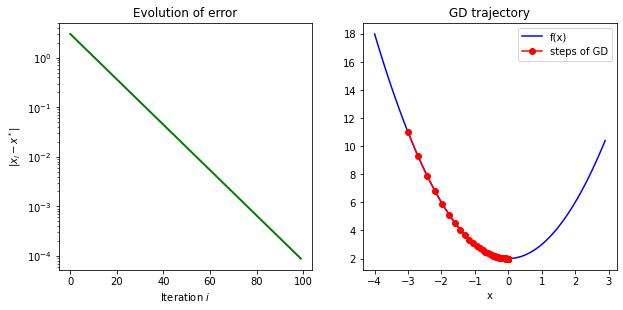

In [189]:
fig = plt.figure()

# plot GD trajectory
ax2 = fig.add_subplot(2, 2, 2)
x_range = np.arange(-4, 3, .1)
ax2.plot(x_range, f(x_range), label='f(x)', color='b')
ax2.plot(x_value_history, func_value_history, '-o', color='r', label='steps of GD')
plt.legend()
plt.title("GD trajectory")
plt.xlabel("x")

# plot error 
x_star = 0  # analytical solution to minization problem
error = np.abs(x_value_history - x_star)
ax1 = fig.add_subplot(2, 2, 1)
line, = ax1.plot(error, color='g', lw=2)
ax1.set_yscale('log')
plt.title('Evolution of error')
plt.xlabel('Iteration $i$')
plt.ylabel('$|x_i-x^*|$')

pylab.show()

The visualization shows that the algorithm converged exponentially and converges to the global optimum, which was expected for a quadratic function.

# Multivariate Minimization
In the follwing, the autograd engine is applied to a multivariate minimization problem. The basic principle is the same as in the previous example, however here the optimization regime is $\mathbb R^2$, as we optimize over $x$ and $y$. The minimization problem will be 
$$x^*, y^* = \text{argmin}\left[{((x^2+y^3)-1) \cdot \exp{(-0.5{(x^2+y^2)})}}\right],$$
which is non-convex.

In [203]:
def z_func(x,y):
    return -(1-(x**2+y**3))*np.exp(-(x**2+y**2)/2)
    

class MulVariableMod(autograd.Module):
    def __init__(self, init_x, init_y):
        super(MulVariableMod, self).__init__()
        self.x = autograd.Variable(init_x) 
        self.y = autograd.Variable(init_y) 
        self.exp = autograd.Exp()  # autograd supports a range of nonlinearities

        print(f"\nStarting initialization: x={self.x.value}, y={self.y.value}")
        self.params.append(self.x)
        self.params.append(self.y)
    
    def forward(self):
        return -(1-(self.x**2+self.y**3))*self.exp(-(self.x**2+self.y**2)/2)
    
    
def perform_2d_gd(initializations, epochs=15):
    n_runs = len(initializations)
    print(f"Performing GD for {n_runs} runs with different initializations:")

    # initializations have shape [runs, 2]
    func_value_history = []  # collecting lists should have shape [runs, epochs] after loop 
    x_value_history = []
    y_value_history = []
    
    for run in range(n_runs):
        module = MulVariableMod(init_x=initializations[run][0], 
                                init_y=initializations[run][1])
        optim = GD(params=module.params, lr=0.3)
        
        func_value_history.append([])
        x_value_history.append([])
        y_value_history.append([])

        for epoch in range(epochs):
            x_value_history[run].append(module.x.value)
            y_value_history[run].append(module.y.value) 

            optim.zero_grad()
            func_value = module.forward()
            func_value.backward()
            optim.step()

            func_value_history[run].append(func_value.value)
            if epoch % 5 == 0:
                print(f"   epoch: {epoch} | x: {module.x.value} | y: {module.y.value} | f(x): {func_value.value}")            
    return np.array(x_value_history), np.array(y_value_history), np.array(func_value_history)

In [204]:
# Perform optimization on multiple starting initializations
initializations = [[0.5, 1.8],
                  [-2, -2], 
                  [-2, 2], 
                  [1.6, -0.1]]
x_value_history, y_value_history, func_value_history = perform_2d_gd(initializations, epochs=15)

Performing GD for 4 runs with different initializations:

Starting initialization: x=0.5, y=1.8
   epoch: 0 | x: 0.5807383783993567 | y: 1.7700099624946193 | f(x): 0.8875458339293328
   epoch: 5 | x: 1.036858823583052 | y: 1.426391821869617 | f(x): 0.6863100274734272
   epoch: 10 | x: 0.902915571191885 | y: 0.6737565756232013 | f(x): 0.2981298791122319

Starting initialization: x=-2, y=-2
   epoch: 0 | x: -1.9230743166673165 | y: -2.0109893833332406 | f(x): -0.0915781944436709
   epoch: 5 | x: -1.2721909876784823 | y: -1.9788068027148267 | f(x): -0.32345837125129856
   epoch: 10 | x: -0.13473778563670605 | y: -1.6076117946197144 | f(x): -1.3221725035854597

Starting initialization: x=-2, y=2
   epoch: 0 | x: -2.0989044499991647 | y: 2.0549469166662027 | f(x): 0.20147202777607598
   epoch: 5 | x: -2.4250522603097915 | y: 2.248601038805441 | f(x): 0.07897849780087501
   epoch: 10 | x: -2.6056976735090593 | y: 2.361537688646649 | f(x): 0.04307878245959654

Starting initialization: x=1.6, 

Function and plot taking from here: [Link](https://glowingpython.blogspot.com/2012/01/how-to-plot-two-variable-functions-with.html)

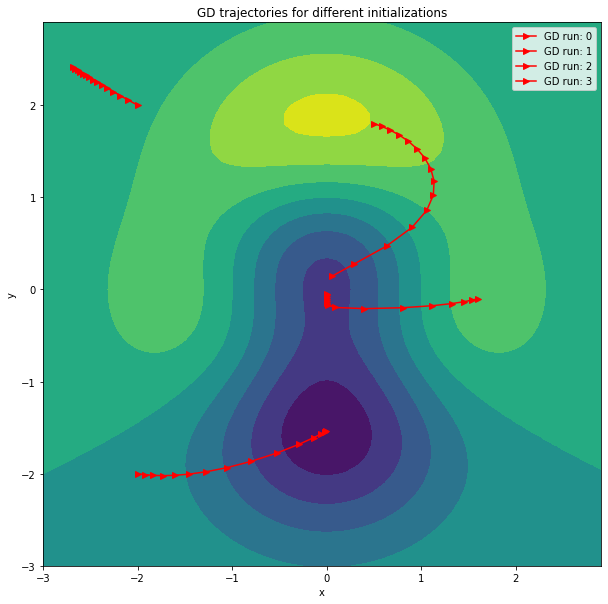

In [205]:
# Plot the GD trajectories
x = np.arange(-3.0,3.0,0.1)
y = np.arange(-3.0,3.0,0.1)
[X, Y] = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1)
Z = z_func(X,Y)
ax.contourf(X, Y, Z)  
ax.set_xlabel('x')
ax.set_ylabel('y')
for run in range(x_value_history.shape[0]):
    plt.plot(x_value_history[run], y_value_history[run], '->', color='r', label=f'GD run: {run}')
plt.title("GD trajectories for different initializations")
plt.legend()
plt.show()

We can nicely see that the GD trajectories are orthogonal to the contour lines. Furthermore, not all runs converge to the global minimum, which is due to the the loss function not being convex.